# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)

## Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

<img src="data/convolution.png" width="70%">

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__. 

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

In [2]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [3]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [4]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros
    
    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

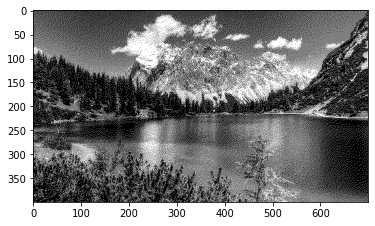

In [ ]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [ ]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

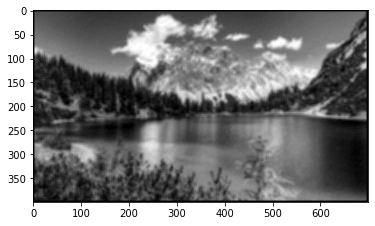

In [ ]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## PyTorch Convolution <a class="anchor" id="pytorch" ></a>

In [ ]:
from PIL import Image

img = Image.open('data/image.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

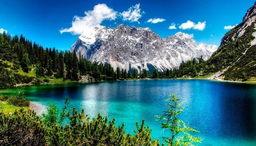

In [ ]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [ ]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [ ]:
input = to_tensor(img)
input.shape


torch.Size([1, 146, 256])

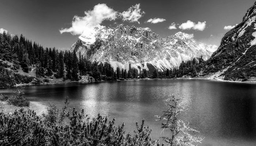

In [ ]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [ ]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [ ]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 1, 3, 3], but got 3-dimensional input of size [1, 146, 256] instead

We need to insert a dimension for a batch at dim=0.

In [ ]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 146, 256])

In [ ]:
output = conv(input)
output.shape

torch.Size([1, 1, 146, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [ ]:
output.shape

torch.Size([1, 1, 146, 256])

We need to remove the first dimension before converting to a PIL object.

In [ ]:
output.data.squeeze(dim=0).shape

torch.Size([1, 146, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

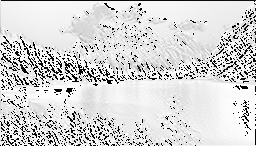

In [ ]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

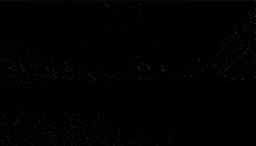

In [ ]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [ ]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

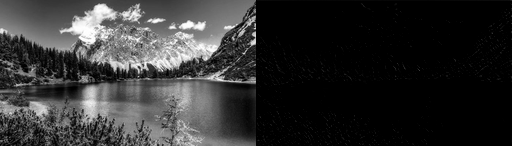

In [ ]:
display(input, output)

### Identity

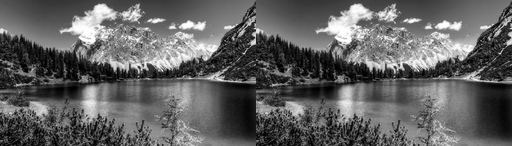

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


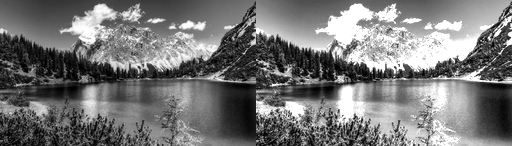

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


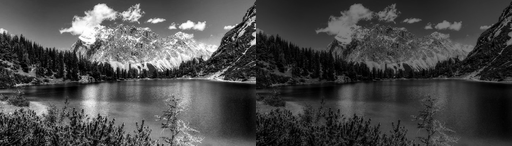

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


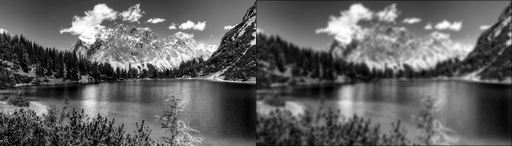

In [ ]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


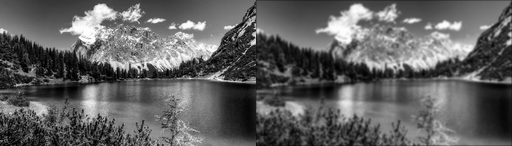

In [ ]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


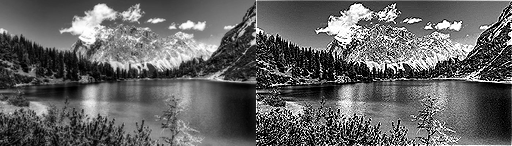

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


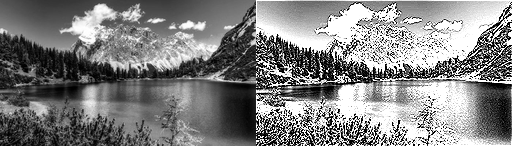

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


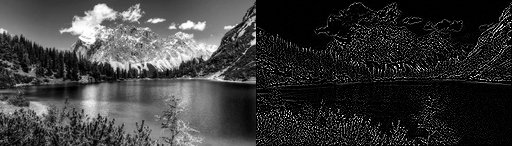

In [ ]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

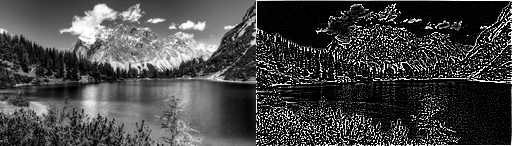

In [ ]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

In [ ]:
# TODO: Challenge, hard image with hard transformations

# 1 Implementación de Detectores de línea

Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cual es más eficiente?

In [116]:
# importing libraries
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import requests

## Utilitary code

In [117]:
def convolution(image: np.array, kernel: np.array) -> np.array:
  """
    peform a convolution operation image * kernel

    Parameters
      image (np.array): Image represented as a numpy array
      kernel (np.array): NxN Kernel used to perform the convolution operation (aka Filter)

    Returns
      np.array: 2d np.array that resulted from the convolution operation
  """
  # getting the reflexion of the given kernel
  kernel = np.flipud(np.fliplr(kernel))
  
  # computing padding factor by floor-dividing the kernel by 2
  paddingFactor = kernel.shape[0] // 2

  # padding image with 0s
  padded_image = np.pad(image, (paddingFactor, paddingFactor))

  # creating output np.array
  output = np.zeros_like(image, dtype=float)

  # deriving offset based kernel shape
  xOffset = kernel.shape[0]
  yOffset = kernel.shape[1]

  # applying kernel (filter) to the given image
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      # element-wise multiplication of the kernel and the image
      output[x, y] = float((kernel * padded_image[x: x + xOffset, y: y + yOffset]).sum())

  return output

In [118]:
def plot(originalImg: np.array, modifiedImg: np.array):
  """
    Display the given images side by side

    Parameters
      ----------
      originalImg (np.array): the original image represented as a numpy array
      modifiedImg (np.array): the updated image represented as a numpy array
  """
  _, ax = plt.subplots(1, 2, figsize=(12, 6))
  ax[0].imshow(originalImg, cmap='gray')
  ax[1].imshow(modifiedImg, cmap='gray');

In [135]:
def createEdgesDetector(operator: str) -> callable :
  """
    Factory edge detector that crea  
    Parameters
      operator (str): edge detector (avaiable prewitt, sobel, and laplacian)

    Returns:
      callable: desired edge detector

    Raises:
      ValueError: if operator is None or not in (prewitt, solbel, and laplacian)
  """

  # raising error if a falsy operator is provided
  if operator == None:
    raise ValueError('operator is required and cannot be None')
  
  # normalizing operator
  operator = operator.lower()

  # defining supported operators and their respectic masks/filters/kernels
  masksByOperator = {
      'prewitt': {
          'x': np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]]),
          'y': np.array([[-1, -1, -1],[0, 0, 0],[1, 1, 1]])
      },
      'sobel': {
          'x': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
          'y': np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
      },
      'laplacian': {
          'x': np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]),
          'y': np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
      }
  }

  # validating that given operator is valid
  if not operator in masksByOperator:
    raise ValueError(f'{operator} is not a valid operator (available options prewitt, sobel, and laplacian)')

  # getting kernel
  KERNEL = masksByOperator[operator]
  
 
  def edgeDetector(imageURI: str, verbose: bool = True) -> np.array: 
    """
      detects edges in the given image
      
      Parameters:
        imageURI (str): absolute URL to the image

      Returns:
        np.array: image containing the edges detected

      Raises:
        ValueError: if imageURI is None
    """
    if imageURI == None:
      raise ValueError('imageURI is required and cannot be None')

    # loading image
    response = requests.get(imageURI)
    img = Image.open(BytesIO(response.content))

    # converts image to grayscale
    grayScaledImage = ImageOps.grayscale(img)

    # defining filters (aka kernel)
    KERNEL_X = KERNEL['x']
    KERNEL_Y = KERNEL['y']

    # "casting" image as np.array
    grayScaledImageData = np.array(grayScaledImage)

    # applying prewitt filter for the X axis
    Gx = convolution(grayScaledImageData, KERNEL_X) 

    # applying prewitt filter for the Y axis
    Gy = convolution(grayScaledImageData, KERNEL_Y) 

    # computing the gradient magnitude
    G = np.sqrt(np.power(Gx, 2) + np.power(Gy, 2)) 

    # plotting image
    if verbose is True:
      plot(img, G)

    return G
    

  return edgeDetector

In [136]:
# Image that will be used run edge detection 
# using prewitt, sobel, and laplacial
TARGET_IMAGE_URI = 'https://raw.githubusercontent.com/jorgetapia-ml/Actividades-Visualizacion-eq17/develop/images/chess.jpeg'

## 1.1 Implementación de algoritmos

### 1.1.1 Prewitt

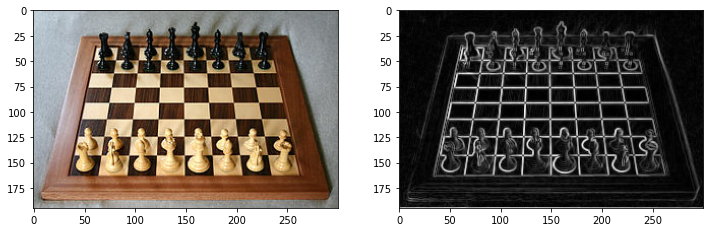

In [137]:
# running prewitt on the target image
_ = createEdgesDetector('prewitt')(TARGET_IMAGE_URI)

### 1.1.2 Sobel

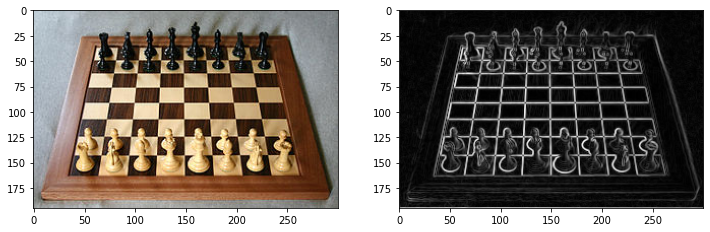

In [138]:
# running sobel on the target image
_ = createEdgesDetector('sobel')(TARGET_IMAGE_URI)

### 1.1.3 Laplacian

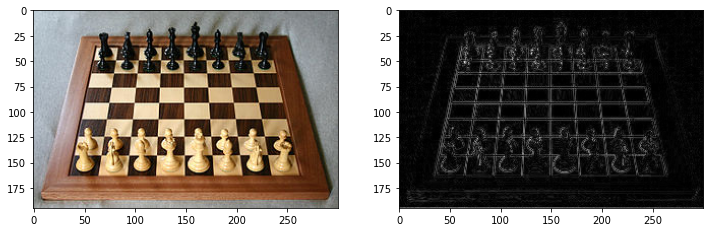

In [139]:
# running laplacian on the target image
_ = createEdgesDetector('laplacian')(TARGET_IMAGE_URI)

## 1.2 Complejidad algoritmica

El trabajo de investigación *Comparative Analysis of Common Edge Detection Techniques in Context of Object Extraction* realizó un estudio comparativo donde puso a prueba diferentes técnicas de detección de lineas con el objetivo de determinar el más eficiente.

El resultado del estudio ofrece la siguiente tabla comparativa

| Operator | Time | Space | Noise sensivity | False Edges |
| --- | --- | --- | --- | --- |
| Sobel | lower | high | Less sensivity | More |
| Canny | high | high | Least sensivity | Least |
| Robert | high | high | Sensivity | More |
| Prewitt | low | lower | Least sensivity | More |
| Laplacian | low | least | Least sensivity | More |
| Zero Crossing | low | less | Least sensivity | More |

En base la información desplegada, se puede concluir que el técnica mas eficiente al comparar Prewitt, Sobel y Laplacian es **Laplacian** ya que en cuestion de complejidad en tiempo y espacio es el más eficiente. Sin embargo, se debe mencionar que el trabajo de investigación concluye que Canny es el mas eficiente.


# 2 Implementación de algoritmo de mejoramiento de imagenes

Implementa un algoritmos de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.


In [140]:
def enhancer(imageURI: str, mode: str = 'smooth', alpha: float = 1.0): 
  """
    Sharps the given image by applying the following algorithm
      1 smooth image / detect edeges
      2 compute mask = original img - (smoothed image or edge detected)
      3 sharpened image = original img + (alpha * computed mask)

    Parameters:
      imageURI (str): absolute URL to the image
      mode (str): specifies type of enhancement (available smooth and edge-detection)
      alpha (float): constant that gets multiplied to the computed mask

    Raises:
        ValueError: if imageURI is None
        ValueError: if mode is not either smooth or edge-detection
  """

  # raising error if imageURI is not provided
  if imageURI == None:
    raise ValueError('imageURI is required and cannot be None')
  
  if mode != 'smooth' and mode != 'edge-detection':
    raise ValueError(f'{mode} unsupported mode available smooth and edge-detection)')
  
  # defining smoothing kernel
  # retrieved from https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm (Figure 3)
  GAUSSIAN_SMOOTHING_KERNEL = (np.array([
      [1, 4, 7, 4, 1],
      [4, 16, 26, 16, 4],
      [7, 26, 41, 26, 7],
      [4, 16, 26, 16, 4],
      [1, 4, 7, 4, 1]
  ]) / 273)

  # loading image
  response = requests.get(imageURI)
  img = Image.open(BytesIO(response.content))

  # converts image to grayscale
  grayScaledImage = ImageOps.grayscale(img)

  # "casting" image as np.array
  grayScaledImageData = np.array(grayScaledImage)

  # applying smoothing or edge detection based on the given mode
  modeResultingImage = convolution(grayScaledImageData, GAUSSIAN_SMOOTHING_KERNEL) if mode == 'smooth' else createEdgesDetector('prewitt')(imageURI, False)
  
  # computing mask
  mask = grayScaledImageData - modeResultingImage

  # sharpening image
  sharpenedImage = grayScaledImageData + (mask * alpha)

  # plotting images
  _, ax = plt.subplots(1, 4, figsize=(20, 10))
  ax[0].imshow(grayScaledImage, cmap='gray')
  ax[0].set_title('Original')
  ax[1].imshow(modeResultingImage, cmap='gray')
  ax[1].set_title('Smoothed' if mode == 'smooth' else 'Detected Edges')
  ax[2].imshow(mask, cmap='gray');
  ax[2].set_title('Mask')
  ax[3].imshow(sharpenedImage, cmap='gray');
  ax[3].set_title('Sharpened')

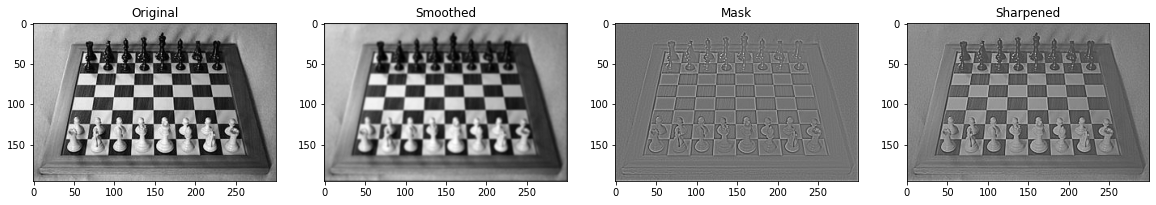

In [142]:
enhancer(TARGET_IMAGE_URI, mode = 'smooth', alpha = 2)

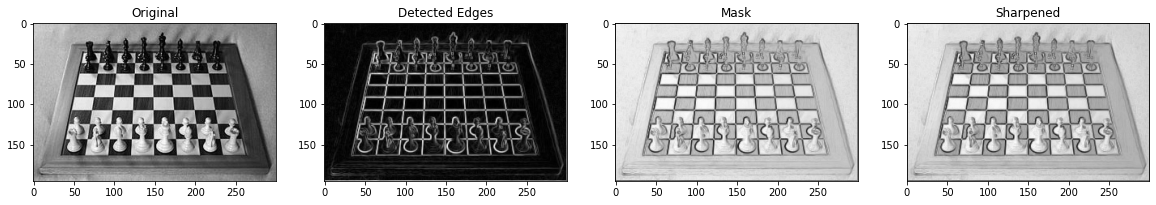

In [145]:
enhancer(TARGET_IMAGE_URI, mode = 'edge-detection', alpha = 2)

# 3 TO-DO

Buscar una aplicación médica (en el libro de Gonzalez viene varios ejemplos de imágenes PET) y hacer mejoramiento usando la técnica de de la Figura 3.43 combinando diferentes etapas de procesamiento de imagenes

## Referencias 

S. Kumar, A. K. Upadhyay, P. Dubey and S. Varshney, "Comparative analysis for Edge Detection Techniques in Context of Object Extraction" 2021 International Conference on Computing, Communication, and Intelligent Systems (ICCCIS), Greater Noida, India, 2021, pp. 675-681, doi: [10.1109/ICCCIS51004.2021.9397225](https://arxiv.org/pdf/1405.6132.pdf).